In [1]:
!git clone https://github.com/parthv21/VOC-Semantic-Segmentation.git
!rm ./VOC-Semantic-Segmentation/main.ipynb
!mv ./VOC-Semantic-Segmentation/* .
!rm -rf VOC-Semantic-Segmentation


Cloning into 'VOC-Semantic-Segmentation'...
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 187 (delta 0), reused 4 (delta 0), pack-reused 180
Receiving objects: 100% (187/187), 714.09 MiB | 38.99 MiB/s, done.
Resolving deltas: 100% (90/90), done.
Checking out files: 100% (30/30), done.


In [12]:
from voc12 import VOC2012
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
import random
import pathlib
import torch

from model.Naive import Naive
from model.FCN_2 import FCN_2
from train_2 import train_2, predict, load_model
from utils.visualization import visualizePrediction, compare_model_performance
from criterion.CrossEntropy import getCrossEntropyLoss

print(torch.__version__)

1.7.0+cu101


### Download Dataset
This command will dowanload dataset and delete old files.

In [4]:
!wget https://s3.amazonaws.com/fast-ai-imagelocal/pascal-voc.tgz 
!tar -xzf ./pascal-voc.tgz
!rm -rf ./pascal-voc/VOC2007
!rm ./pascal-voc.tgz

--2020-11-27 18:49:00--  https://s3.amazonaws.com/fast-ai-imagelocal/pascal-voc.tgz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.98.205
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.98.205|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4639722845 (4.3G) [application/x-tar]
Saving to: ‘pascal-voc.tgz’

pascal-voc.tgz      100%[===================>]   4.32G  43.3MB/s    in 2m 48s  

2020-11-27 18:51:48 (26.4 MB/s) - ‘pascal-voc.tgz’ saved [4639722845/4639722845]



In [11]:
voc2012 = VOC2012('./pascal-voc/VOC2012/')

ptrain = pathlib.Path('./voc2012_train.h5')
pval = pathlib.Path('./voc2012_val.h5')

if ptrain.is_file() and pval.is_file():
    voc2012.load_all_data()
else:
    voc2012.read_all_data_and_save()

loading ./voc2012_train.h5
loading ./voc2012_val.h5


Train count:  1464
Val count:  1449
Train image:  (224, 224, 3)
Train label:  (224, 224)
Unique classes:  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


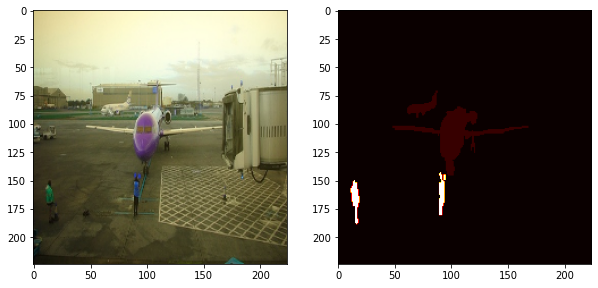

In [10]:
print("Train count: ", len(voc2012.train_images))
print("Val count: ", len(voc2012.val_images))

print("Train image: ", voc2012.train_images[0].shape)
print("Train label: ", voc2012.train_labels[0].shape)

print("Unique classes: ", np.unique(voc2012.train_labels))


plt.subplots(1,2, figsize=(10,10)) # specifying the overall grid size


plt.subplot(1,2,1)    # the number of images in the grid is 5*5 (25)
plt.imshow(voc2012.train_images[0])

plt.subplot(1,2,2)    # the number of images in the grid is 5*5 (25)
plt.imshow(voc2012.train_labels[0], cmap='hot')

plt.show()


### Model Loading
Use this to load a trained model. You will need to have the calss file in the same relative location where it was when the model was trained for this to work. The commented line is used to load an older version of the checkpoint where the contents of the checkpoint were different. 

In [ ]:
# Naive model training 
trainModel = False



if trainModel:
    naive = Naive()
    train(naive, voc2012, model_name="naive", criterionType="ce", weighted=True, num_epochs=12, batch_size=1, learning_rate=1e-3, weight_decay=1e-5)

else:
    from model.Unet import UNet
    unet = UNet(21)
    optimizer = torch.optim.Adam(naive.parameters(), lr=1e-3, weight_decay=1e-5)
    if torch.cuda.is_available():
#         unet = torch.load("./model/unet_ce.pt")
        checkpoint = torch.load("./model/naive_ce_weighted.pt")
        start_epoch = checkpoint['epoch']
        naive.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    else:
#         print(unet)
#         unet = torch.load("./model/unet_ce.pt", map_location=torch.device('cpu'))
        checkpoint = torch.load("./model/naive_ce_weighted.pt")
        start_epoch = checkpoint['epoch']
        naive.load_state_dict(checkpoint['state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer'])
    naive.eval()
    print(naive)


Naive(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.01)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  )
  (decorder): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(256, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(128, 64, kernel_size=(3

Trained with cross entropy loss for 200 iterations. The boundaries are a lot better.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

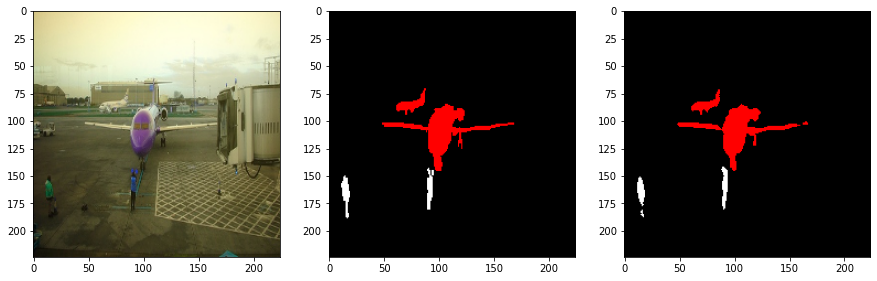

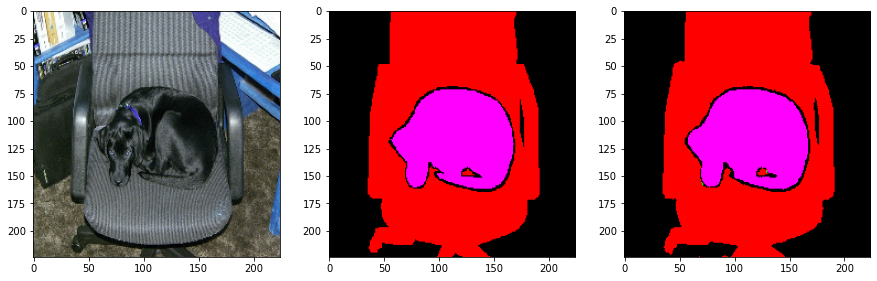

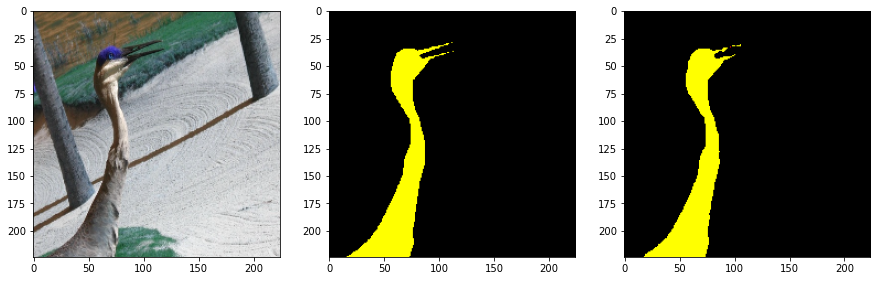

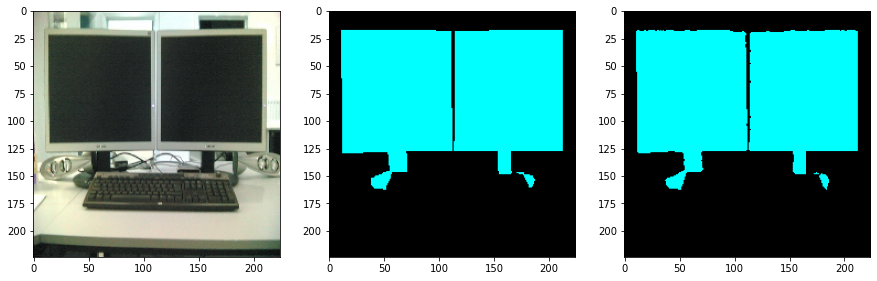

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

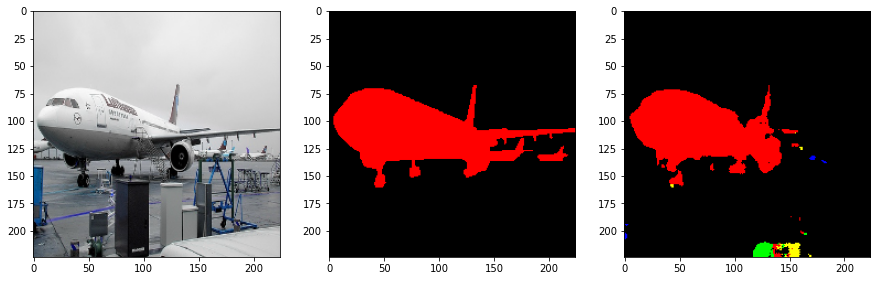

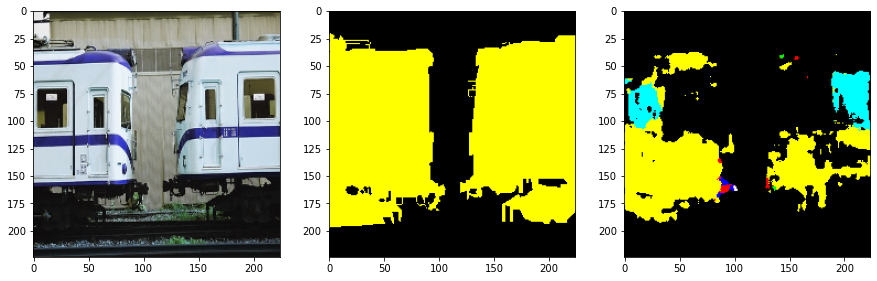

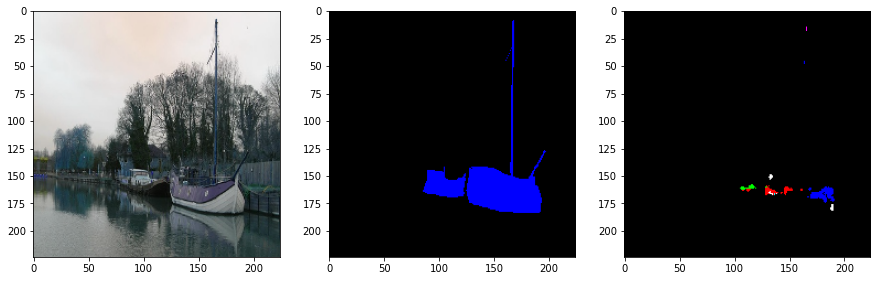

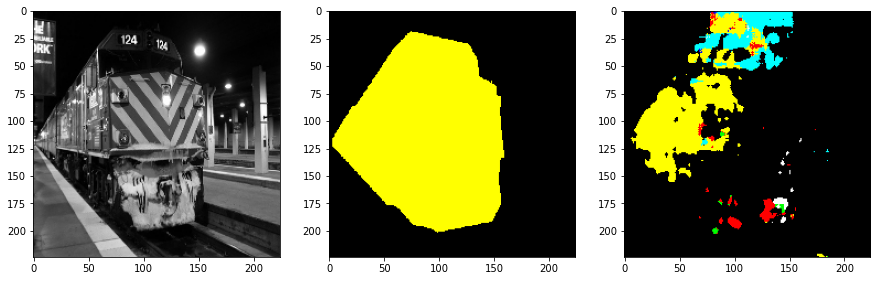

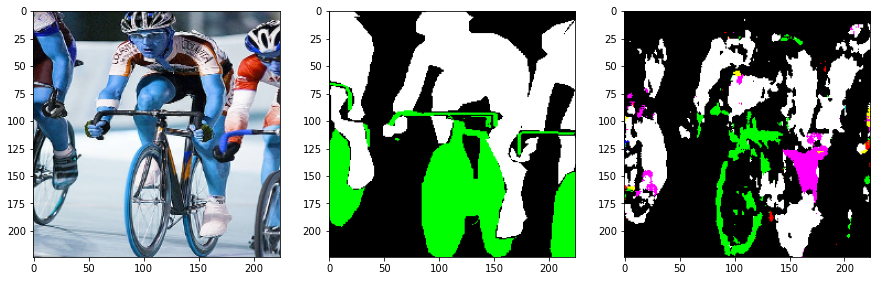

In [ ]:
fcn = FCN()
if torch.cuda.is_available():
#     checkpoint = torch.load("./model/fcn_200.pt")
#     fcn.load_state_dict(checkpoint)

    fcn = torch.load("./model/fcn_200_freez.pt")

else:
#     checkpoint = torch.load("./model/fcn_200.pt", map_location=torch.device('cpu'))
#     fcn.load_state_dict(checkpoint)
    
    fcn = torch.load("./model/fcn_200_freez.pt", map_location=torch.device('cpu'))

# print(fcn)
# cuda_avail = torch.cuda.is_available()
# if cuda_avail:
#     torch.cuda.manual_seed(0)
# else:
#     torch.manual_seed(0)
# model,_ ,_ = load_model(name)

ind = range(0,5)
visualizePrediction(fcn, voc2012.train_images[ind], voc2012.train_labels[ind])
visualizePrediction(fcn, voc2012.val_images[ind], voc2012.val_labels[ind])

In [8]:
train_2(model_name="fcn_2",name_prefix="alt_" , criterionType="ce", weighted=True, num_epochs=200, batch_size=16, learning_rate=5e-4, weight_decay=1e-5)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth



Model Architecture to be Trained: 
FCN_2(
  (pool4): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size

FCN_2(
  (pool4): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

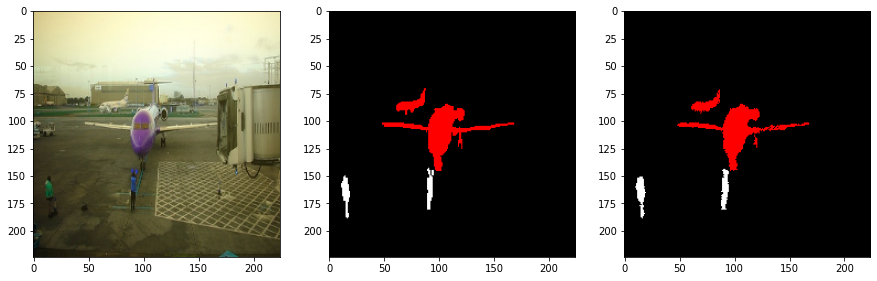

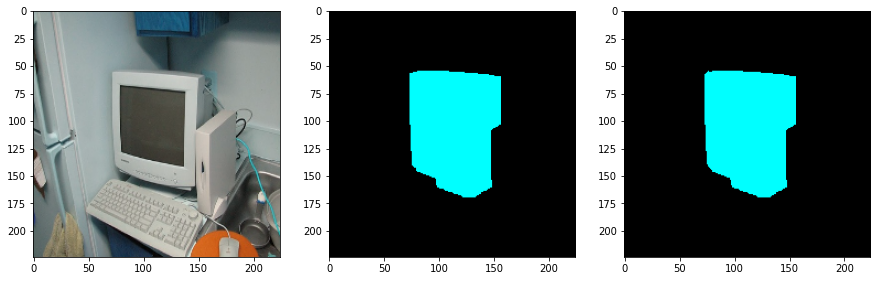

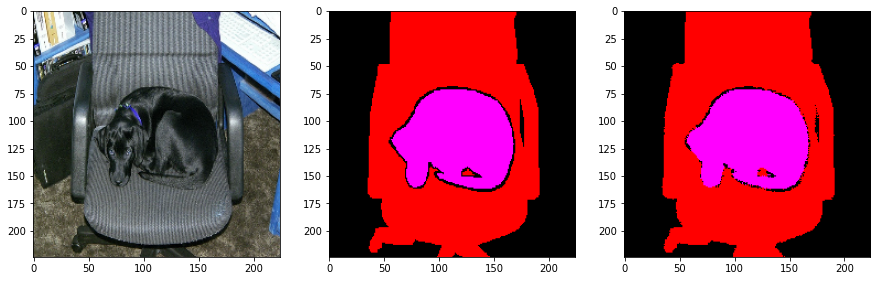

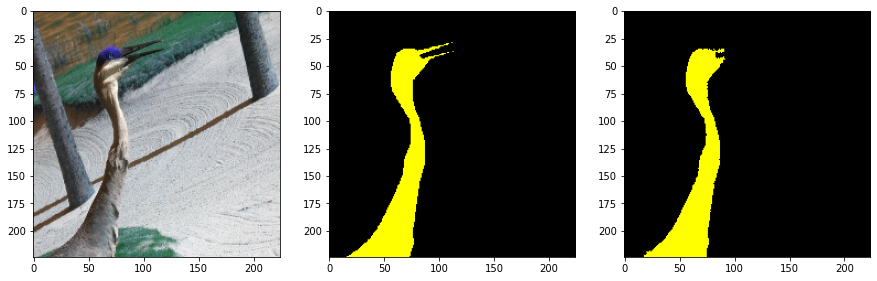

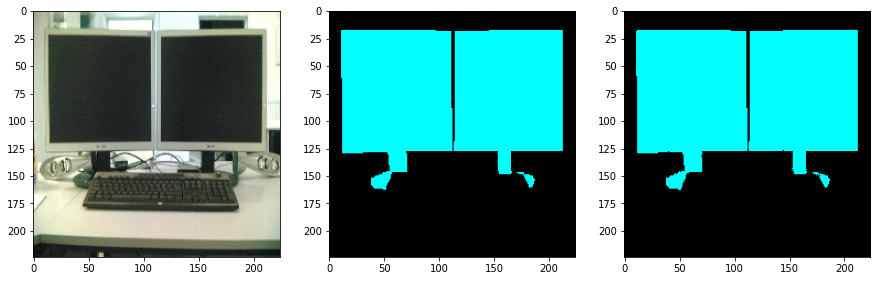

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

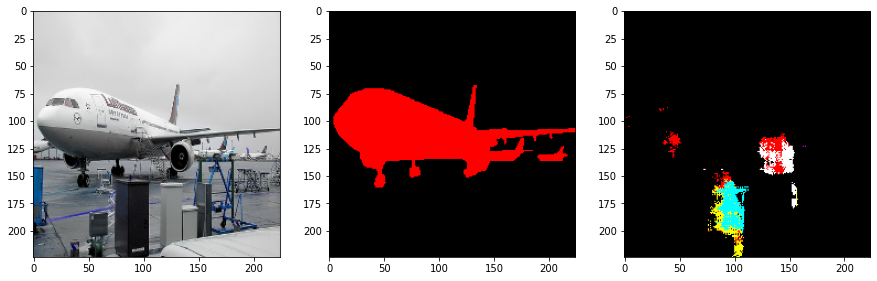

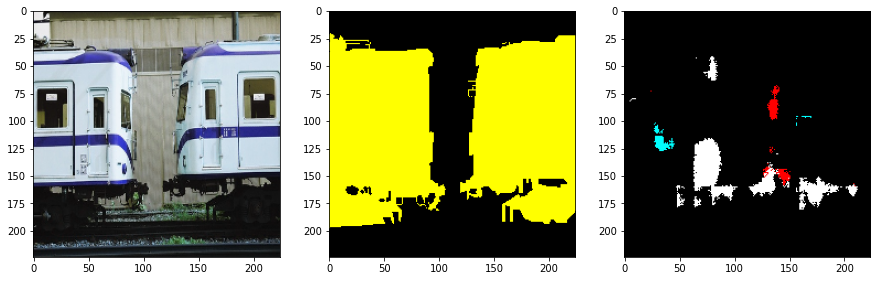

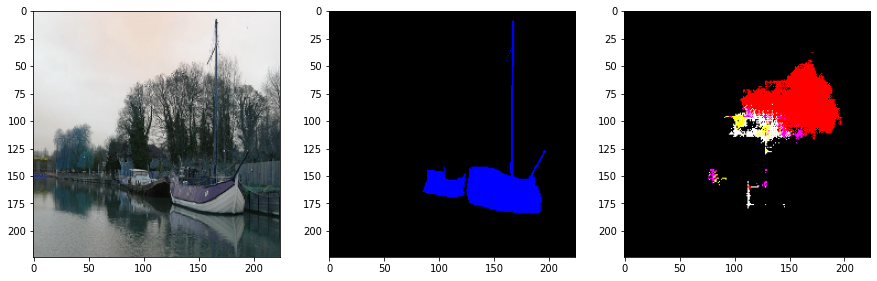

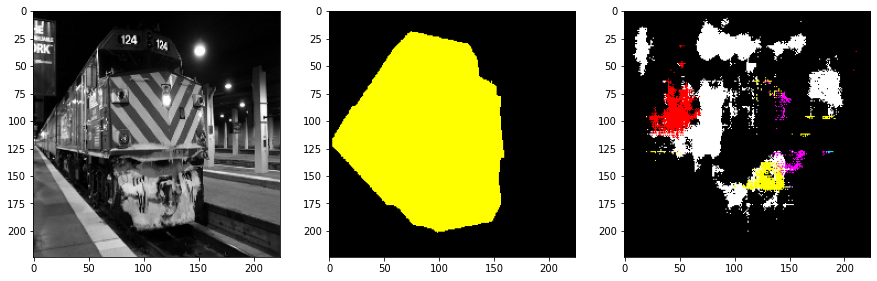

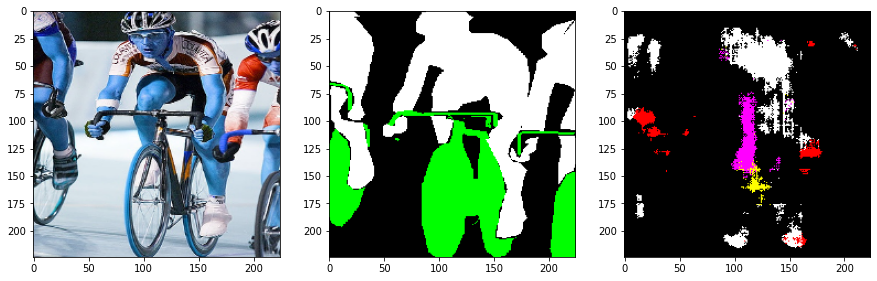

In [13]:
fcn_2 = FCN_2()
if torch.cuda.is_available():
#     checkpoint = torch.load("./model/fcn_200.pt")
#     fcn.load_state_dict(checkpoint)

    fcn_2 = torch.load("./model/fcn_2_ce_weighted.pt")

else:
#     checkpoint = torch.load("./model/fcn_200.pt", map_location=torch.device('cpu'))
#     fcn.load_state_dict(checkpoint)
    
    fcn_2 = torch.load("./model/fcn_2_ce_weighted.pt", map_location=torch.device('cpu'))

# print(fcn)
# cuda_avail = torch.cuda.is_available()
# if cuda_avail:
#     torch.cuda.manual_seed(0)
# else:
#     torch.manual_seed(0)
# model,_ ,_ = load_model(name)

ind = range(0,5)
visualizePrediction(fcn_2, voc2012.train_images[ind], voc2012.train_labels[ind])
visualizePrediction(fcn_2, voc2012.val_images[ind], voc2012.val_labels[ind])